# Classification Models and Hyperparameter Finetuning

In [104]:
import matplotlib.pyplot as plt
#%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics 
from sklearn.datasets import make_classification
#from xgboost import XGBClassifier
#!pip install xgboost scikit-learn pandas numpy
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import pickle

In [105]:
## V1
# def classificationMetrics(y, yhat):
#     prf1 = metrics.precision_recall_fscore_support(y,yhat)
#     res = {'Accuracy': metrics.accuracy_score(y,yhat),
#            'Precision':prf1[0][1],
#            'Recall': prf1[1][1],
#            'f1-score': prf1[2][1],
#            'Log-loss': metrics.log_loss(y,yhat),
#            'AUC': metrics.roc_auc_score(y,yhat)
#           }
#     return res

## V2

def classificationMetrics(y, yhat, y_proba=None):
    prf1 = metrics.precision_recall_fscore_support(y, yhat, average='weighted', zero_division=0)
    
    res = {
        'Accuracy': metrics.accuracy_score(y, yhat),
        'Precision': prf1[0],
        'Recall': prf1[1],
        'f1-score': prf1[2]
    }

    # Add log-loss & AUC only if probabilities are available
    if y_proba is not None:
        try:
            res['Log-loss'] = metrics.log_loss(y, y_proba, labels=np.unique(y))
        except:
            res['Log-loss'] = np.nan
        try:
            res['AUC'] = metrics.roc_auc_score(y, y_proba, multi_class='ovr')
        except:
            res['AUC'] = np.nan

    return res

## Data

In [106]:
# load df for modeling
with open("../pickles/df_model.pkl", "rb") as f:
    df_model = pickle.load(f)  

# load dev for modeling
with open("../pickles/dev.pkl", "rb") as f:
    dev = pickle.load(f)  

# load test for modeling
with open("../pickles/test.pkl", "rb") as f:
    test = pickle.load(f)  

# load train for modeling
with open("../pickles/train.pkl", "rb") as f:
    train = pickle.load(f)  

In [107]:
df_model

,season,home_xGoals,home_ppda,home_total_xAssists,home_total_xGoalsChain,away_xGoals,away_deep,away_ppda,away_total_xAssists,away_total_xGoalsChain,...,home_yellowCards_cat,home_shotsOnTarget_cat,away_shotsOnTarget_cat,home_corners_cat,home_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,home_discipline_score_avg,away_discipline_score_avg,gameresult
5437,2014,1.367870,31.6000,1.283730,2.784246,2.655380,11.0,7.5000,1.725767,9.988565,...,0,3,6,1,3,1,2,0.000000,0.000000,1
5438,2014,1.396890,5.7429,0.232187,0.877201,1.317510,1.0,4.7826,0.498085,2.524986,...,3,4,4,1,7,1,2,-23.000000,-18.000000,1
5439,2014,0.813737,7.0000,0.739955,3.146696,1.238690,1.0,21.2143,0.709868,3.464242,...,1,2,7,5,2,2,4,-17.500000,-15.500000,0
5440,2014,0.632940,16.0625,0.562167,2.009705,1.495320,2.0,10.7500,0.180901,1.149532,...,3,3,2,4,1,3,0,-16.333333,-15.333333,0
5441,2014,1.544680,3.6087,0.897067,0.864974,0.057137,0.0,21.0556,0.000000,0.034394,...,0,3,1,8,5,3,1,-13.250000,-17.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,2020,1.411190,12.3684,0.971853,3.853730,1.707510,3.0,8.3529,0.307960,1.223212,...,2,5,5,9,6,4,3,-13.833333,-19.250000,0
12676,2020,1.198190,16.2632,0.855524,1.962812,1.238050,4.0,27.0000,0.775388,2.610665,...,1,3,5,5,3,2,3,-14.692308,-18.769231,0
12677,2020,1.332690,8.2857,1.151649,7.684589,0.357583,0.0,39.7273,0.216965,0.884652,...,1,6,2,4,2,4,2,-14.785714,-18.285714,2
12678,2020,1.460500,7.5600,1.265829,4.790546,1.380290,3.0,14.7200,0.565077,1.256511,...,1,5,2,9,5,5,1,-14.933333,-17.800000,0


In [108]:
df_model.shape

(12680, 22)

In [109]:
dev.shape

(2536, 23)

Visual of the data created on stage 5 with RandomOverSample techniqe

[Text(0.5, 1.0, 'Data after Over Sampling')]

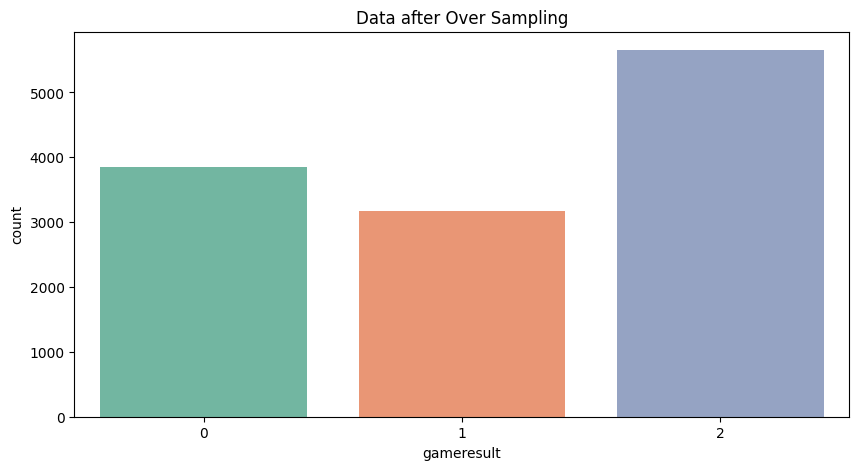

In [110]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df_model['gameresult'].dropna(),data=df_model, palette="Set2").set(title='Data after Over Sampling')

In [111]:
df_model['gameresult'].value_counts()

2    5654
0    3854
1    3172
Name: gameresult, dtype: int64

In [112]:
X_train = train.loc[:,train.columns != 'gameresult']
X_dev = dev.loc[:,dev.columns != 'gameresult']
y_train = train['gameresult']
y_dev = dev['gameresult']

In [113]:
y_dev

10682    0
10794    1
2455     2
6463     0
168      1
        ..
3475     1
1487     1
4070     0
4404     2
9411     2
Name: gameresult, Length: 2536, dtype: int64

## Supervised Models


In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

In [115]:
models_list = pd.DataFrame()

In [116]:
X_dev['split'] = X_dev['split'].astype('category').cat.codes

X_dev.dtypes

season                            int64
home_xGoals                     float64
home_ppda                       float64
home_total_xAssists             float64
home_total_xGoalsChain          float64
away_xGoals                     float64
away_deep                       float64
away_ppda                       float64
away_total_xAssists             float64
away_total_xGoalsChain          float64
home_redCards_binary               bool
away_redCards_binary               bool
home_yellowCards_cat            float64
home_shotsOnTarget_cat          float64
away_shotsOnTarget_cat          float64
home_corners_cat                float64
home_total_blocked_shots_cat    float64
home_total_saved_shots_cat      float64
away_total_saved_shots_cat      float64
home_discipline_score_avg       float64
away_discipline_score_avg       float64
split                              int8
dtype: object

## Linear Regression

In [117]:
X_train.select_dtypes(include=['object']).nunique()


Series([], dtype: float64)

In [118]:
X_train.dtypes.sort_values()


home_redCards_binary               bool
away_redCards_binary               bool
season                            int64
home_total_xAssists             float64
home_discipline_score_avg       float64
away_total_saved_shots_cat      float64
home_total_saved_shots_cat      float64
home_total_blocked_shots_cat    float64
home_corners_cat                float64
away_shotsOnTarget_cat          float64
home_shotsOnTarget_cat          float64
home_ppda                       float64
home_yellowCards_cat            float64
away_discipline_score_avg       float64
away_total_xGoalsChain          float64
away_total_xAssists             float64
away_ppda                       float64
away_deep                       float64
away_xGoals                     float64
home_total_xGoalsChain          float64
home_xGoals                     float64
split                           float64
dtype: object

In [119]:
# X_train = X_train.drop(columns=['split'])  # example
# X_dev = X_dev.drop(columns=['split'])


In [120]:
# Option 1: Convert entire DataFrame (safe for encoded data)
X_dev = X_dev.apply(pd.to_numeric, errors='raise')
X_train = X_train.apply(pd.to_numeric, errors='raise')


In [121]:
mod1 = LogisticRegression(random_state=1, max_iter=1000)
mod1.fit(X_train,y_train)
pred1 = mod1.predict(X_dev)
proba1 = mod1.predict_proba(X_dev)

In [122]:
model_dict = {'model': "Logistic Regression"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred1,proba1)}, ignore_index=True)

In [123]:
pd.crosstab(y_dev, pred1)


col_0,0,1,2
gameresult,,,
0,583,72,99
1,209,153,277
2,74,100,969


## Decision Tree


In [124]:
mod2 = DecisionTreeClassifier(random_state=1)
mod2.fit(X_train,y_train)
pred2= mod2.predict(X_dev)
proba2 = mod2.predict_proba(X_dev)

model_dict = {'model': "Decision Tree"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred2, proba2)}, ignore_index=True)

In [125]:
pd.crosstab(y_dev, pred2)


col_0,0,1,2
gameresult,,,
0,471,176,107
1,192,230,217
2,128,247,768


## Random Forest


In [126]:
mod3 = RandomForestClassifier(random_state=1)
mod3.fit(X_train,y_train)
pred3 = mod3.predict(X_dev)
proba3 = mod3.predict_proba(X_dev)

model_dict = {'model': "RandomForest"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred3, proba3)}, ignore_index=True)

In [127]:
pd.crosstab(y_dev, pred3)

col_0,0,1,2
gameresult,,,
0,572,89,93
1,197,152,290
2,86,81,976


## Adaptive Boosting (ADABoost)

In [128]:
mod4 = AdaBoostClassifier(random_state=1)
mod4.fit(X_train,y_train)
pred4 = mod4.predict(X_dev)
proba4 = mod4.predict_proba(X_dev)

model_dict = {'model': "ADABoost"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred4, proba4)}, ignore_index=True)

In [129]:
pd.crosstab(y_dev, pred4)


col_0,0,1,2
gameresult,,,
0,573,123,58
1,198,203,238
2,68,102,973


## Gradient Boosting Machine (GBM)

In [130]:
mod5 = GradientBoostingClassifier(random_state=1)
mod5.fit(X_train,y_train)
pred5 = mod5.predict(X_dev)
proba5 = mod5.predict_proba(X_dev)

model_dict = {'model': "GBM"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred5, proba5)}, ignore_index=True)

In [131]:
pd.crosstab(y_dev, pred5)

col_0,0,1,2
gameresult,,,
0,640,89,25
1,165,279,195
2,21,81,1041


## Support Vector Machine (SVM)

In [132]:
mod6 = SVC(probability=True)
mod6.fit(X_train,y_train)
pred6 = mod6.predict(X_dev)
proba6 = mod6.predict_proba(X_dev)

model_dict = {'model': "SVM"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred6, proba6)}, ignore_index=True)

In [133]:
pd.crosstab(y_dev, pred6)

col_0,2
gameresult,
0,754
1,639
2,1143


## XGBoost parallel tree boosting (GBDT, GBM)

In [134]:
from xgboost import XGBClassifier
mod7 = XGBClassifier(random_state=1)
mod7.fit(X_train,y_train)
pred7 = mod7.predict(X_dev)
proba7 = mod7.predict_proba(X_dev)

model_dict = {'model': "XGB"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred7,proba7)}, ignore_index=True)

In [135]:
pd.crosstab(y_dev, pred7)

col_0,0,1,2
gameresult,,,
0,657,83,14
1,145,333,161
2,19,93,1031


## Model Selection

In [136]:
models_list.sort_values('AUC',ascending=False)

,model,Accuracy,Precision,Recall,f1-score,Log-loss,AUC
6,XGB,0.796924,0.788081,0.796924,0.789870,0.476745,0.926107
4,GBM,0.772871,0.759015,0.772871,0.760434,0.561755,0.908014
0,Logistic Regression,0.672319,0.643490,0.672319,0.645054,0.745471,0.822948
2,RandomForest,0.670347,0.641540,0.670347,0.642735,0.758743,0.817808
3,ADABoost,0.689669,0.668145,0.689669,0.673399,1.077065,0.790230
5,SVM,0.450710,0.203139,0.450710,0.280055,0.860120,0.761793
1,Decision Tree,0.579259,0.582770,0.579259,0.580739,15.165054,0.670229


# update needed

## Based on performance metrics (Accuracy, F1, Log-loss, and AUC), Logistic Regression and XGBoost provide the best overall classification performance, with perfectly calibrated predictions and clean probability separation. Models like Random Forest and GBM follow closely. AdaBoost underperforms significantly and may require further tuning or replacement.

🧠 Key Factors for Model Choice
Factor	Consideration
Accuracy / F1	Logistic Regression, XGB, GBM all strong
Log-loss (probability quality)	Logistic Regression & XGB best
Interpretability	Logistic Regression > Tree-based models
Scalability / Speed	Logistic Regression fast, XGB scales well
Overfitting risk	Check cross-validation — GBM/XGB may overfit
Deployment constraints	Any restrictions (e.g. explainability?)

🔍 Final Recommendation
🏆 Primary candidate for fine-tuning: XGBoost
Performs nearly as well as logistic regression on all metrics

Offers better flexibility and non-linearity handling

Handles missing values, outliers, and feature interactions automatically

Highly tunable for performance, with great libraries/tools (e.g. Optuna, CV)

## Hyperparameter Finetuning for XGBoost Model (XGB)

 XGBoost Import Block

In [137]:
# Core XGBoost models
from xgboost import XGBClassifier, XGBRegressor

# Model tuning and splitting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score, f1_score, log_loss, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# For early stopping and eval sets
import xgboost as xgb

# Native XGBoost CV (optional, for advanced users)
from xgboost import cv, DMatrix


In [138]:
test

,season,home_xGoals,home_ppda,home_total_xAssists,home_total_xGoalsChain,away_xGoals,away_deep,away_ppda,away_total_xAssists,away_total_xGoalsChain,...,home_shotsOnTarget_cat,away_shotsOnTarget_cat,home_corners_cat,home_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,home_discipline_score_avg,away_discipline_score_avg,gameresult,split
9123,2018,1.354740,6.1111,1.182628,1.025618,0.484752,5.000000,10.8800,0.305696,0.905245,...,5.0,6.0,10.0,3.0,2.0,4.0,-28.000000,-26.000000,2,0.0
809,2015,1.030380,2.2500,0.634875,2.760650,0.263110,2.000000,12.7333,0.205247,0.577086,...,5.0,4.0,7.0,9.0,3.0,2.0,-26.928571,-27.785714,1,0.0
780,2015,0.744526,7.5758,0.541279,1.120400,1.413000,9.000000,6.0476,0.865091,4.211229,...,4.0,5.0,7.0,6.0,2.0,2.0,-22.328984,-24.104167,0,0.0
265,2015,2.074880,10.8571,1.528366,5.236435,1.216380,3.000000,8.1000,0.934175,1.840798,...,7.0,4.0,6.0,1.0,2.0,0.0,-21.374037,-20.793103,2,0.0
12190,2020,1.754310,3.3704,1.073796,4.081372,0.547118,4.000000,23.8000,0.504012,0.899477,...,10.0,4.0,2.0,9.0,7.0,1.0,-20.875000,-20.111111,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,2014,1.495350,10.6190,0.552496,3.685556,3.363920,3.000000,12.4615,2.898960,4.809696,...,8.0,11.0,12.0,4.0,5.0,4.0,-15.459459,-17.810811,0,0.0
11262,2020,1.474980,7.6000,1.323135,1.247887,1.407060,6.000000,4.7647,1.253420,3.484246,...,8.0,6.0,4.0,3.0,5.0,2.0,-24.653283,-22.076923,0,0.0
3731,2014,0.600074,10.0000,0.570147,2.078904,1.517170,4.824998,11.6923,0.677178,2.772529,...,4.0,6.0,5.0,2.0,1.0,1.0,-16.821429,-19.357143,0,0.0
439,2016,0.569734,10.9583,0.522914,0.855076,0.776105,1.000000,9.6111,0.545509,1.371013,...,6.0,4.0,10.0,6.0,2.0,2.0,-20.799917,-23.943396,2,0.0


In [139]:
del test['split']

In [140]:
X_test = test.loc[:,test.columns != 'gameresult']
y_test = test['gameresult']

## Random Search

In [141]:
# 1. Initialize base model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [142]:
# 2. Define hyperparameter grid
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
max_features = ['auto', 'sqrt']  # Note: XGBoost uses 'colsample_bytree' instead
min_child_weight = [50]  # Like min_samples_leaf
subsample = [0.8]

In [143]:
# Map to XGBoost params
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': min_child_weight,
    'subsample': subsample,
    'learning_rate': [0.01, 0.05, 0.1]
}

In [144]:
print("Random Grid:", random_grid)

Random Grid: {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'colsample_bytree': [0.8, 1.0], 'min_child_weight': [50], 'subsample': [0.8], 'learning_rate': [0.01, 0.05, 0.1]}


In [145]:
# 3. Randomized Search
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=random_grid,
    n_iter=50,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    cv=5,
    n_jobs=-1
)

In [146]:
del X_train['split']

In [147]:
# Fit model
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_child_weight': [50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'subsample': [0.8]},
                   random_state=42, scoring='accuracy', verbose=2)

In [148]:
def evaluate(model, X, y):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted', zero_division=0)
    recall = recall_score(y, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y, predictions, average='weighted', zero_division=0)
    mae = mean_absolute_error(y, predictions)
    print('Model Performance')
    print(f"Accuracy:         {accuracy:.4f}")
    print(f"Precision:        {precision:.4f}")
    print(f"Recall:           {recall:.4f}")
    print(f"F1-score:         {f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    return accuracy

In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7608 entries, 8859 to 11119
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   season                        7608 non-null   int64  
 1   home_xGoals                   7608 non-null   float64
 2   home_ppda                     7608 non-null   float64
 3   home_total_xAssists           7608 non-null   float64
 4   home_total_xGoalsChain        7608 non-null   float64
 5   away_xGoals                   7608 non-null   float64
 6   away_deep                     7608 non-null   float64
 7   away_ppda                     7608 non-null   float64
 8   away_total_xAssists           7608 non-null   float64
 9   away_total_xGoalsChain        7608 non-null   float64
 10  home_redCards_binary          7608 non-null   bool   
 11  away_redCards_binary          7608 non-null   bool   
 12  home_yellowCards_cat          7608 non-null   float64
 13 

In [150]:
trained_columns = X_train.columns

In [151]:
# Ensure test/dev sets match training features
X_test = X_test.reindex(columns=trained_columns, fill_value=0)
X_dev = X_dev.reindex(columns=trained_columns, fill_value=0)


In [152]:

# Baseline model
base_model = XGBClassifier(n_estimators=1000, random_state=4, use_label_encoder=False, eval_metric='logloss')
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Accuracy:         0.8064
Precision:        0.8016
Recall:           0.8064
F1-score:         0.8033
Mean Absolute Error: 0.2110


In [153]:
# Best from Randomized Search
best_random = xgb_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:.2f}%'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy:         0.7981
Precision:        0.7944
Recall:           0.7981
F1-score:         0.7959
Mean Absolute Error: 0.2188
Improvement of -1.03%


In [154]:
# Dev set
base_accuracy_dev = evaluate(base_model, X_dev, y_dev)
random_accuracy_dev = evaluate(best_random, X_dev, y_dev)
print('Improvement on dev: {:.2f}%'.format(100 * (random_accuracy_dev - base_accuracy_dev) / base_accuracy_dev))

Model Performance
Accuracy:         0.7942
Precision:        0.7867
Recall:           0.7942
F1-score:         0.7887
Mean Absolute Error: 0.2212
Model Performance
Accuracy:         0.7894
Precision:        0.7824
Recall:           0.7894
F1-score:         0.7845
Mean Absolute Error: 0.2259
Improvement on dev: -0.60%


In [155]:
# 4. Grid Search CV (refine)
param_grid = {
    'max_depth': [55, 60],
    'colsample_bytree': [0.8],
    'min_child_weight': [45, 50],
    'n_estimators': [1000]
}


In [156]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'max_depth': [55, 60],
                         'min_child_weight': [45, 50], 'n_estimators': [1000]},
             verbose=2)

In [157]:
# Evaluate best grid
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Grid Search Improvement: {:.2f}%'.format(100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy:         0.7768
Precision:        0.7714
Recall:           0.7768
F1-score:         0.7734
Mean Absolute Error: 0.2449
Grid Search Improvement: -3.67%


In [158]:
grid_accuracy_dev = evaluate(best_grid, X_dev, y_dev)
print('Grid Dev Improvement: {:.2f}%'.format(100 * (grid_accuracy_dev - base_accuracy_dev) / base_accuracy_dev))

Model Performance
Accuracy:         0.7681
Precision:        0.7594
Recall:           0.7681
F1-score:         0.7622
Mean Absolute Error: 0.2496
Grid Dev Improvement: -3.28%


In [159]:
# Save best model
final_model = xgb_random.best_estimator_
print("Final model ready for production:", final_model)

Final model ready for production: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...)


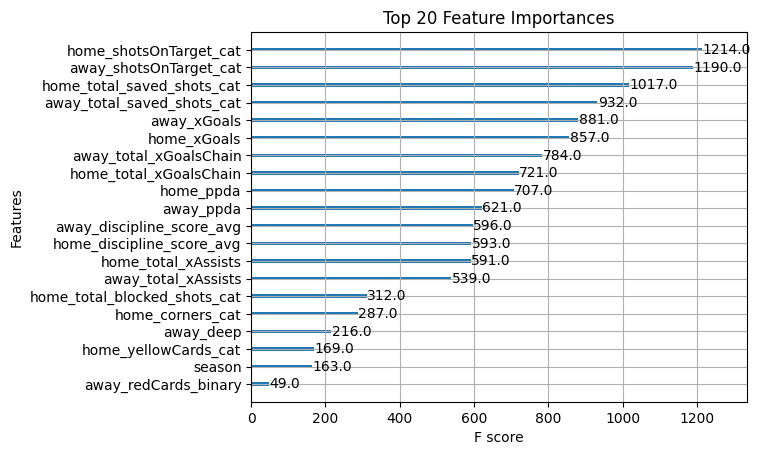

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=110, min_child_weight=50, n_estimators=100, subsample=0.8; total time=   7.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=60, min_child_weight=50, n_estimators=100, subsample=0.8; total time=   9.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=80, min_child_weight=50, n_estimators=900, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=100, min_child_weight=50, n_estimators=400, subsample=0.8; total time=  50.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=70, min_child_weight=50, n_estimators=400, subsample=0.8; total time=  41.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=30, min_child_weight=50, n_estimators=600, subsample=0.8; total time=  57.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=110, min_child_weight=50, n_estimators=700, subsample=0.8; total time= 1.2min
[CV] END colsample_bytree=0.8, lea

In [160]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(final_model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()
